# Training/Test split
- Create $N-1$ equidistant splits where $N$ is the number of covered years
- For each split normalize the distributions and compute the KL divergence between the training and test set
- Finally, compute the maximum KL divergence and plot both the histograms 

In [132]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [133]:
# Get the merged malware data
df = pd.read_csv("vt_reports/merge.csv")
df.head()

,sha256,first_submission_date,family
0,98f8e26e12b978102fa39c197f300ebe5fe535617737d5...,1630575593,tnega
1,7b2999ffadbc3b5b5c5e94145ca4e2f8de66ac1e3ddd52...,1629375559,quasar
2,e7569d494fe00be04ef6c9fcc5e54720c0df623b08e79d...,1362057319,pasta
3,1ed60c04f572b6acb9f64c31db55ef5c6b5465bd4da1eb...,1630624233,cjishu
4,4c4aaff20a57213d9a786e56ad22f1eaa94694a2f1042b...,1592186154,kingsoft


In [134]:
fsd = "first_submission_date"

In [135]:
# Convert the date to datetime
df_dt = df.copy()
df_dt[fsd] = df_dt[fsd].apply(lambda t: pd.to_datetime(t, unit='s'))

In [136]:
fsd = "first_submission_date"

# Min and maximum dates
date_min = df_dt[fsd].min()
date_max = df_dt[fsd].max()

# Create equidistant splits
date_splits = [pd.Timestamp(f"{date_min.year}-{date_min.month}-{date_min.day}") +
               pd.Timedelta(i * (date_max - date_min).days / (date_max.year - date_min.year), unit='D')
               for i in range(1, date_max.year - date_min.year)]

In [137]:
# Split the source DataFrame based on the given condition
def split_and_normalize(src_df: pd.DataFrame,
                        split_condition: bool,
                        split_label: str = ""):
    dst_df = src_df[split_condition]
    dst_df = dst_df.groupby(["family"]).size().reset_index(name='count')
    dst_df["perc"] = dst_df["count"] / dst_df["count"].sum()
    dst_df["split"] = split_label
    return dst_df


# Compute Kullback-Leibler Divergence between p and q
def kl_divergence(p, q):
    epsilon = 1e-7
    p = np.clip(p, epsilon, 1 - epsilon)
    q = np.clip(q, epsilon, 1 - epsilon)
    return np.sum(p * np.log(p / q))

In [158]:
# Compute the KL divergence for each possible split
df_split = df_dt.copy()
kl_divergences = []
overlapping_scores = []
for date_split in date_splits:
    # Split the dataset
    df_train = split_and_normalize(df_split, df_split[fsd] < date_split)
    df_test = split_and_normalize(df_split, df_split[fsd] >= date_split)
    kl_divergences.append(kl_divergence(df_train["perc"], df_test["perc"]))
    overlapping_scores.append(
        len(np.intersect1d(df_train["family"].unique(), df_test["family"].unique())) / 
        len(df["family"].unique())
    )

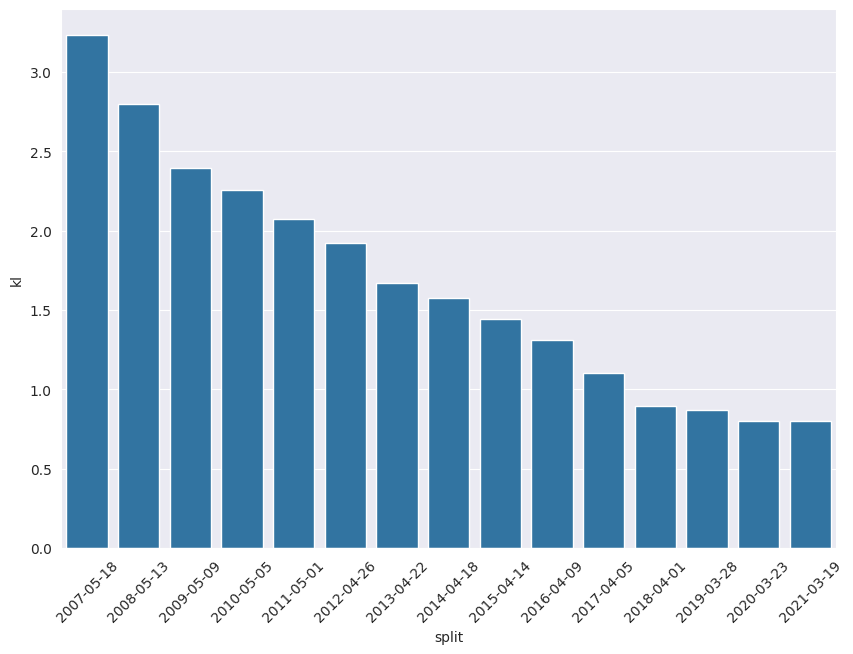

In [155]:
df_merge_kl = pd.DataFrame({"split": date_splits, "kl": kl_divergences})
plt.figure(figsize=(10, 7))
sns.barplot(data=df_merge_kl, x="split", y="kl")
plt.title("KL divergence between train/test data")
plt.xticks(rotation=45)
plt.show()

In [169]:
# Print Max KL divergence and normalize them
max_kl = np.max(kl_divergences)
print(f"Max KL divergence: {max_kl}")
kl_divergence_scores = [kl / max_kl for kl in kl_divergences]

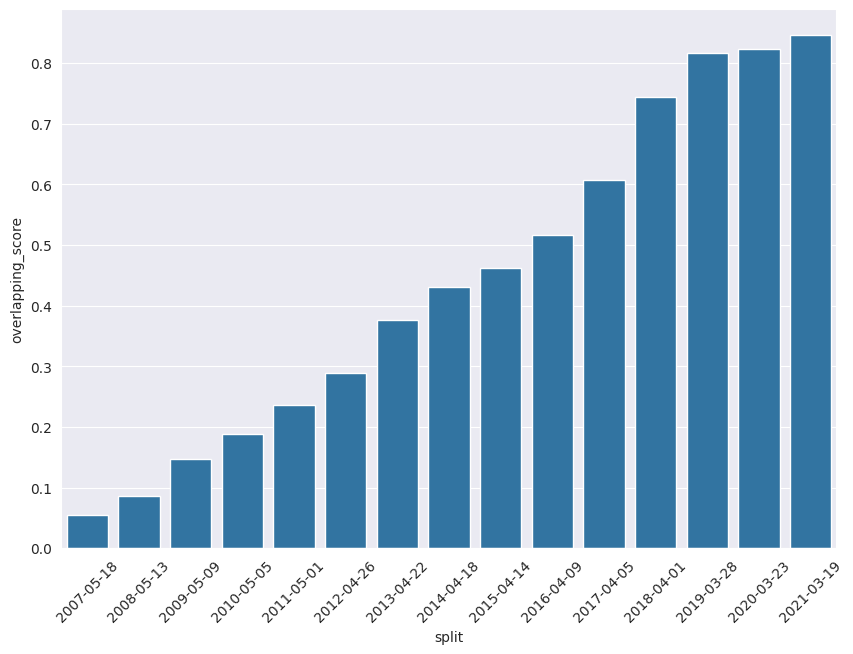

In [171]:
plt.figure(figsize=(10, 7))
sns.barplot(data=pd.DataFrame({"split": date_splits, "overlapping_score": overlapping_scores}), 
            x="split", y="overlapping_score")
plt.title("Overlapping score")
plt.xticks(rotation=45)
plt.show()

In [166]:
split_f = []
for i in range(len(kl_divergence_scores)):
    split_f.append(kl_divergence_scores[i] + overlapping_scores[i])

max_f, max_f_idx = np.max(split_f), np.argmax(split_f)
best_split = date_splits[max_f_idx]
print(f"Best split is achieved at: {best_split}, Objective function value: {max_f}")

Best split is achieved at: 2021-03-19 00:00:00, Objective function value: 1.0937019365776979


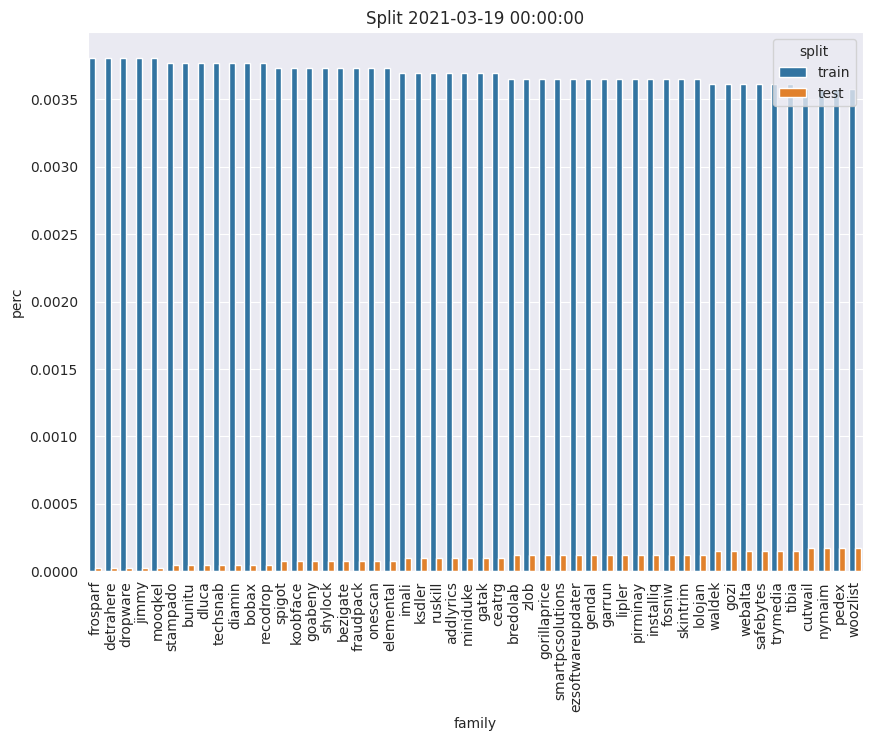

In [168]:
# Split the dataset
df_train = split_and_normalize(df_split, df_split[fsd] < best_split, "train")
df_test = split_and_normalize(df_split, df_split[fsd] >= best_split, "test")

df_merge_kl = pd.merge(left=df_train, right=df_test, on="family")
df_merge_kl["diff"] = abs(df_merge_kl["perc_x"] - df_merge_kl["perc_y"])

# Take the top 40 rows that maximizes the difference 
df_merge_kl = df_merge_kl.sort_values(by="diff", ascending=False).head(50)

data = lambda p, s: {"family": df_merge_kl["family"],
                     "perc": df_merge_kl[p],
                     "split": df_merge_kl[s]
                     }
df_train = pd.DataFrame(data("perc_x", "split_x"))
df_test = pd.DataFrame(data("perc_y", "split_y"))

df_merge = pd.concat([df_train, df_test])
plt.figure(figsize=(10, 7))
plt.title(f"Split {best_split}")
sns.barplot(data=df_merge, x="family", y="perc", hue="split")
plt.xticks(rotation=90)
plt.show()